In [6]:
import os
import sqlite3
import pandas as pd
import seaborn as sns
from pathlib import Path
from contextlib import closing
import matplotlib.pyplot as plt
from google.protobuf.json_format import MessageToDict

from events.gen import messages_pb2, asd_events_pb2
from utils.build_raw_inputs import find_sim_db, find_scenarios

ROOT = Path("/store/kruu/eye_tracking/training_data")
SAVE = Path("asd")

In [ ]:
def build_df(pid: str, sid: str, db_dir: str, batch_size: int = 50_000):
    events = []
    event_obj = messages_pb2.Event()

    with closing(sqlite3.connect(f"{Path(db_dir).as_uri()}?immutable=1", uri=True)) as con:
        con.text_factory = bytes
        cur = con.cursor()
        cur.execute("SELECT epoch_ms, payload FROM events")
        
        while (rows := cur.fetchmany(batch_size)):
            for epoch_ms, payload in rows:
                event_obj.ParseFromString(payload)
                
                asd_event = event_obj.asd_event.WhichOneof("event")

                if asd_event is not None:
                    events.append((epoch_ms, asd_event, MessageToDict(getattr(event_obj.asd_event, asd_event)), pid, sid))

    return pd.DataFrame(events, columns=["epoch_ms", "event_name", "data", "participant", "scenario"])


for pid, sid, scen_dir in find_scenarios(ROOT):
    try:
        db_dir = find_sim_db(scen_dir)
        df = build_df(pid, sid, db_dir)
        print(f"[{pid} {sid}] Extracted {len(df):,} ASD events from {db_dir}")
        df.to_parquet(SAVE / f"p{pid}_s{sid}.parquet")
    
    except sqlite3.DatabaseError as e:
        print(f"[{pid} {sid}] DatabaseError: {e} {db_dir}")


pd.concat(pd.read_parquet(SAVE/f) for f in os.listdir(SAVE)).to_parquet(SAVE/"asd.parquet")

[001 1] Extracted 65,565 ASD events from /store/kruu/eye_tracking/training_data/001/Scenario 1/simulator/001_sept_scenario_1.db
[001 2] Extracted 80,904 ASD events from /store/kruu/eye_tracking/training_data/001/Scenario 2/simulator/001_sept_scenario_2.db
[001 3] Extracted 73,539 ASD events from /store/kruu/eye_tracking/training_data/001/Scenario 3/simulator/001_sept_scenario_3.db
[002 1] Extracted 72,505 ASD events from /store/kruu/eye_tracking/training_data/002/Scenario 1/simulator/002_sept_scenario_1.db
[002 2] Extracted 70,321 ASD events from /store/kruu/eye_tracking/training_data/002/Scenario 2/simulator/polaris-events-2025-09-10T07:59:22.db
[002 3] Extracted 64,755 ASD events from /store/kruu/eye_tracking/training_data/002/Scenario 3/simulator/002_sept_scenario_3.db
[003 1] Extracted 68,989 ASD events from /store/kruu/eye_tracking/training_data/003/Scenario 1/simulator/003_sept_scenario_1.db
[003 2] Extracted 83,382 ASD events from /store/kruu/eye_tracking/training_data/003/Scena

In [19]:
df = pd.read_parquet(SAVE/"asd.parquet")
event_names = [field.name for field in asd_events_pb2.Event.DESCRIPTOR.oneofs_by_name["event"].fields]
df['event_name'] = pd.Categorical(df['event_name'], categories=event_names, ordered=True)
df

,epoch_ms,event_name,data,participant,scenario
index,,,,,
0,1758697868960,mouse_position,"{'x': 2539, 'y': 1788}",001,1
1,1758697869010,mouse_position,"{'x': 2139, 'y': 1519}",001,1
2,1758697869110,mouse_position,"{'x': 2045, 'y': 1320}",001,1
3,1758697869110,mouse_position,"{'x': 2041, 'y': 1287}",001,1
4,1758697869160,mouse_position,"{'x': 2041, 'y': 1100}",001,1
...,...,...,...,...,...
95779,1758285111511,track_label_position,"{'x': 2741, 'y': 1014, 'width': 75, 'height': ...",023,3
95780,1758285114631,track_screen_position,"{'x': 2675, 'y': 1019, 'visible': True, 'fligh...",023,3
95781,1758285114631,track_label_position,"{'x': 2742, 'y': 1014, 'width': 75, 'height': ...",023,3


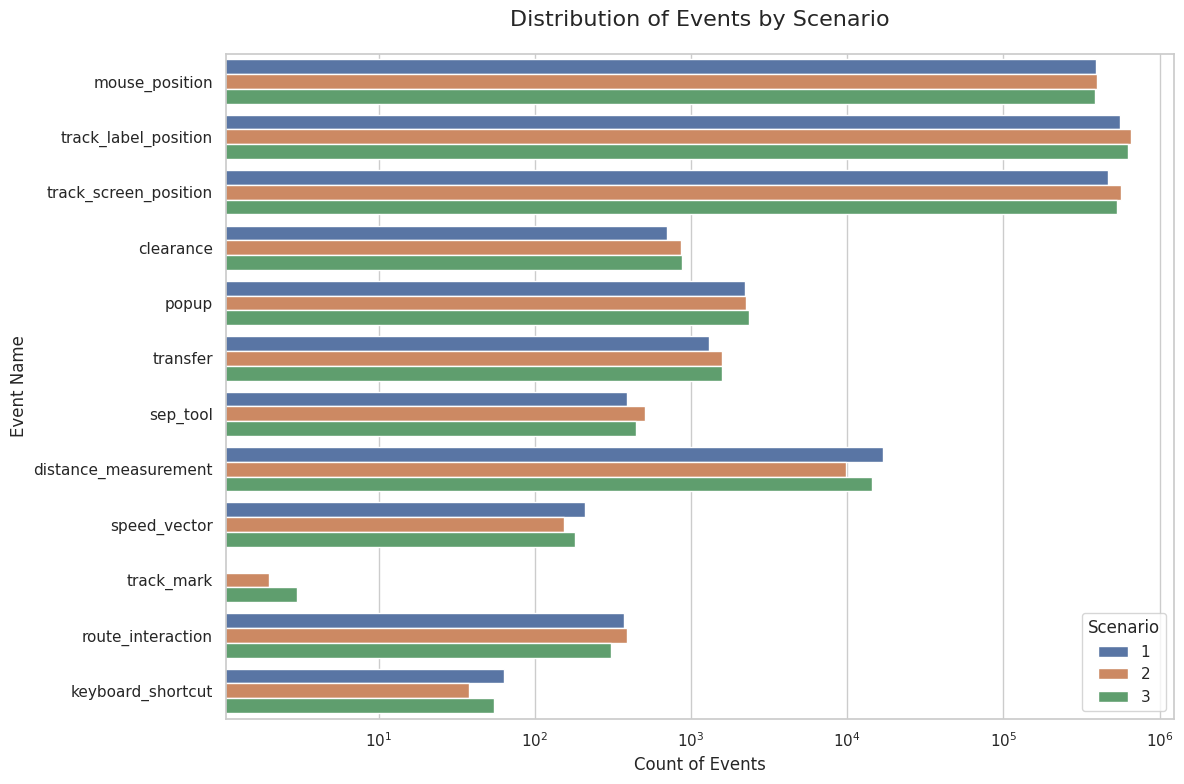

In [7]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))

sns.countplot(
    data=df,
    y="event_name",
    hue="scenario",
    ax=ax
)
ax.set_xscale('log')

ax.set_title("Distribution of Events by Scenario", fontsize=16, pad=20)
ax.set_xlabel("Count of Events", fontsize=12)
ax.set_ylabel("Event Name", fontsize=12)
ax.legend(title="Scenario", loc="lower right")

plt.tight_layout()
plt.show()

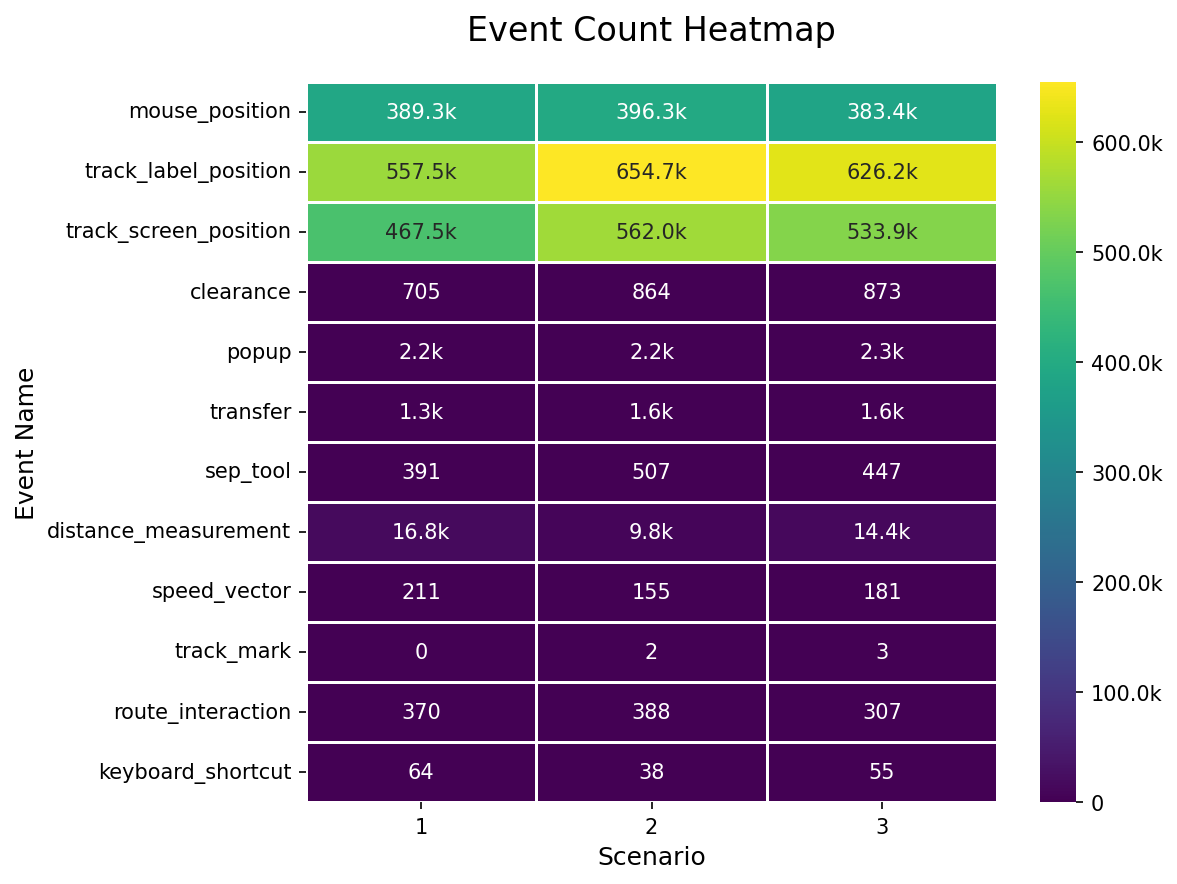

In [ ]:
from matplotlib.ticker import FuncFormatter

# Create the base count matrix ---
count_matrix = pd.crosstab(df['event_name'], df['scenario'])


def number_formatter(x):
    if x >= 1_000_000:
        return f'{x*1e-6:.1f}M'
    if x >= 1_000:
        return f'{x*1e-3:.1f}k'
    return f'{int(x)}'


plt.style.use('default')
plt.figure(figsize=(8, 6), dpi=150)
heatmap = sns.heatmap(
    count_matrix,
    annot=True,
    fmt='d',
    linewidths=.5,
    cmap='viridis',
    cbar_kws={'format': FuncFormatter(number_formatter)}
)

# Apply custom number formatting function
for t in heatmap.texts:
    val = float(t.get_text())
    t.set_text(number_formatter(val))

plt.title('Event Count Heatmap', fontsize=16, pad=20)
plt.xlabel('Scenario', fontsize=12)
plt.ylabel('Event Name', fontsize=12)
plt.xticks(rotation=0) # Keep scenario labels horizontal
plt.yticks(rotation=0) # Keep event names horizontal

plt.tight_layout()
plt.show()